<a href="https://colab.research.google.com/github/Jothish2283/Model-deployment/blob/main/Model_deployment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Getting data**

In [ ]:
!pip -q install torch_snippets;
import requests
import zipfile
from pathlib import Path
import torch
from torch_snippets import*


dir="pizza_steak_sushi_20_percent"
if zipfile.is_zipfile("pizza_steak_sushi_20_percent.zip"):
  print("Data is already exists, skipping download")
else:
  request=requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi_20_percent.zip")

  #downloading
  with open("pizza_steak_sushi_20_percent.zip", "wb") as local_file:
    local_file.write(request.content)
    local_file.close

  #making a sep dir
  Path(dir).mkdir(parents=True, exist_ok=True)

  #extracting
  zip_ref=zipfile.ZipFile("pizza_steak_sushi_20_percent.zip")
  zip_ref.extractall(dir)
  zip_ref.close()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.9/58.9 kB 5.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.5/110.5 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.0/60.0 kB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 10.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 202.8/202.8 kB 19.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 14.1/14.1 MB 86.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 86.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.8/98.8 kB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 109.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 172.5/172.5 kB 20.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 83.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 468.5/468.5 kB 37.3 MB/s eta 0:

In [ ]:
train_dir="/content/pizza_steak_sushi_20_percent/train"
test_dir="/content/pizza_steak_sushi_20_percent/test"

In [ ]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

#**Model Setup**

##**1.Effnet B2**

###**1.1.EFFNET_B2 Class**

In [ ]:
import torch
from torch import nn
import torchvision

class EFFNET_B2(nn.Module):
  def __init__(self):
    super().__init__()
    self.effnet_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
    self.effnet_transfromer= self.effnet_weights.transforms()
    self.loss=nn.CrossEntropyLoss( label_smoothing=0.1) #regularization to help prevent overfitting

  def create_model(self, num_classes):
    effnet_model= torchvision.models.efficientnet_b2(weights=self.effnet_weights)
    for params in effnet_model.parameters():
      params.requires_grad=False

    effnet_model.classifier=nn.Sequential(nn.Dropout(0.2),
                                          nn.Linear(in_features=1408, out_features=num_classes),
                                          nn.Softmax(dim=1))
    return self.effnet_transfromer, effnet_model

  def calc_loss_and_acc(self, y_preds, y):
    loss=self.loss(y_preds, y)
    y_preds=y_preds.argmax(dim=1)
    correct=torch.eq(y_preds, y).sum().item()
    acc=correct/len(y_preds)

    return loss, acc

In [ ]:
eff=EFFNET_B2()
effnet_t, effnet_model= eff.create_model(num_classes=3)

Downloading: "https://download.pytorch.org/models/efficientnet_b2_rwightman-bcdf34b7.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b2_rwightman-bcdf34b7.pth
100%|██████████| 35.2M/35.2M [00:00<00:00, 42.7MB/s]


In [ ]:
!pip install torchinfo
from torchinfo import summary

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
summary(effnet_model, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                                  Input Shape               Output Shape              Param #                   Trainable
EfficientNet                                            [1, 3, 224, 224]          [1, 3]                    --                        Partial
├─Sequential: 1-1                                       [1, 3, 224, 224]          [1, 1408, 7, 7]           --                        False
│    └─Conv2dNormActivation: 2-1                        [1, 3, 224, 224]          [1, 32, 112, 112]         --                        False
│    │    └─Conv2d: 3-1                                 [1, 3, 224, 224]          [1, 32, 112, 112]         (864)                     False
│    │    └─BatchNorm2d: 3-2                            [1, 32, 112, 112]         [1, 32, 112, 112]         (64)                      False
│    │    └─SiLU: 3-3                                   [1, 32, 112, 112]         [1, 32, 112, 112]         --                        --
│    └─Sequential

###**1.2.Datasets and dataloader**

In [ ]:
import os

train_dataset=torchvision.datasets.ImageFolder(root=train_dir,
                                               transform=effnet_t)
test_dataset=torchvision.datasets.ImageFolder(root=test_dir,
                                               transform=effnet_t)

train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

In [ ]:
labels2targets=train_dataset.class_to_idx
targets2labels={k:j for (j,k) in labels2targets.items()}
labels2targets, targets2labels

({'pizza': 0, 'steak': 1, 'sushi': 2}, {0: 'pizza', 1: 'steak', 2: 'sushi'})

In [ ]:
def train_step(model, inputs, optimizer, criterion):
  x, y=inputs
  x, y= x.to(device), y.to(device)
  model.to(device)
  model.train()
  y_preds=model(x)
  loss, acc=criterion(y_preds, y)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()
  return loss.item(), acc

In [ ]:
def validate_step(model, inputs, criterion, scheduler):
  x, y=inputs
  x, y= x.to(device), y.to(device)
  model.to(device)
  model.eval()
  with torch.inference_mode():
    y_preds=model(x)
    loss, acc=criterion(y_preds, y)
    scheduler.step(loss)
    return loss.item(), acc

In [ ]:
EPOCHS=10
model=effnet_model
criterion=eff.calc_loss_and_acc
optimizer=torch.optim.Adam(params=effnet_model.parameters())
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
log_effnet=Report(EPOCHS)

###**1.3.Training**

In [ ]:
for epoch in range(EPOCHS):
  n=len(train_dataloader)
  for idx, inputs in enumerate(train_dataloader):
    loss, acc=train_step(model, inputs, optimizer, criterion)
    pos=epoch+(idx+1)/n
    log_effnet.record(pos=pos, train_loss=loss, train_acc= acc, end="\r")

  n=len(test_dataloader)
  for idx, inputs in enumerate(test_dataloader):
    loss, acc=validate_step(model, inputs, criterion, scheduler)
    pos=epoch+(idx+1)/n
    log_effnet.record(pos=pos, val_loss=loss, val_acc= acc, end="\r")

  log_effnet.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 1.037  val_loss: 0.933  val_acc: 0.898  train_acc: 0.562  (7.29s - 65.57s remaining)
EPOCH: 2.000  train_loss: 0.912  val_loss: 0.872  val_acc: 0.922  train_acc: 0.800  (18.45s - 73.81s remaining)
EPOCH: 3.000  train_loss: 0.840  val_loss: 0.814  val_acc: 0.932  train_acc: 0.875  (31.08s - 72.53s remaining)
EPOCH: 4.000  train_loss: 0.782  val_loss: 0.778  val_acc: 0.966  train_acc: 0.908  (41.25s - 61.88s remaining)
EPOCH: 5.000  train_loss: 0.760  val_loss: 0.750  val_acc: 0.929  train_acc: 0.892  (54.26s - 54.26s remaining)
EPOCH: 6.000  train_loss: 0.758  val_loss: 0.729  val_acc: 0.944  train_acc: 0.927  (62.63s - 41.75s remaining)
EPOCH: 7.000  train_loss: 0.739  val_loss: 0.706  val_acc: 0.960  train_acc: 0.881  (70.33s - 30.14s remaining)
EPOCH: 8.000  train_loss: 0.702  val_loss: 0.712  val_acc: 0.923  train_acc: 0.938  (78.54s - 19.63s remaining)
EPOCH: 9.000  train_loss: 0.701  val_loss: 0.692  val_acc: 0.969  train_acc: 0.898  (89.65s - 9.96s remai

100%|██████████| 111/111 [00:00<00:00, 18560.35it/s]


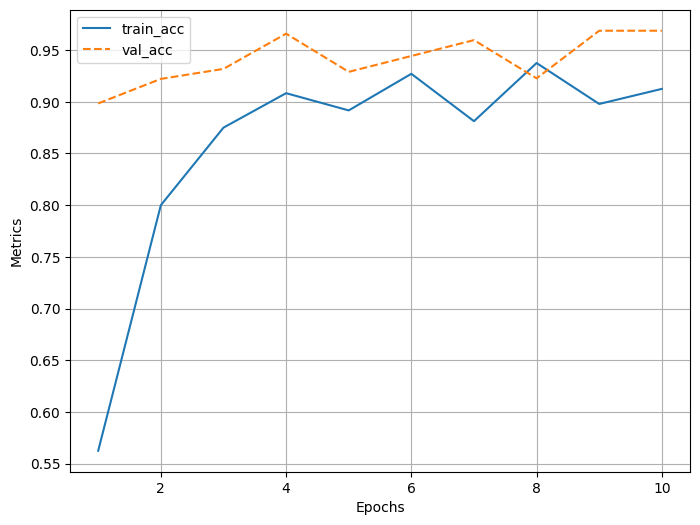

In [ ]:
log_effnet.plot_epochs(["train_acc","val_acc"])

100%|██████████| 111/111 [00:00<00:00, 15550.54it/s]


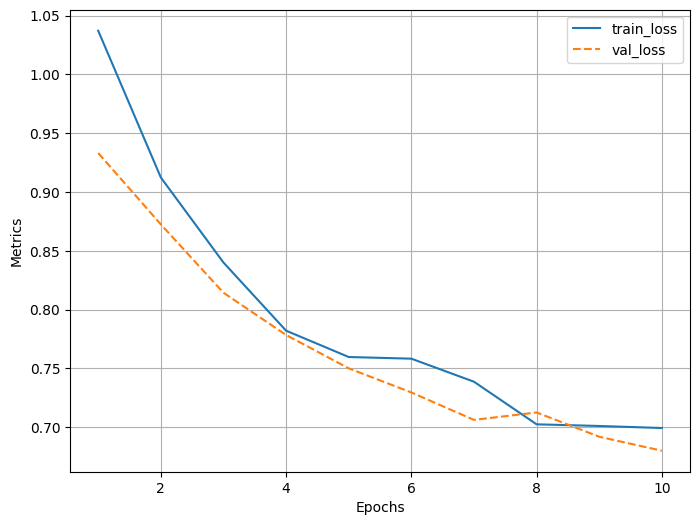

In [ ]:
log_effnet.plot_epochs(["train_loss","val_loss"])

In [ ]:
val_loss=log_effnet.report_avgs(10)["epoch_val_loss"];
val_acc=log_effnet.report_avgs(10)["epoch_val_acc"];
val_loss, val_acc

EPOCH: 10.000  train_loss: 0.699  val_loss: 0.680  val_acc: 0.969  train_acc: 0.912  (100.37s - 0.00s remaining)
EPOCH: 10.000  train_loss: 0.699  val_loss: 0.680  val_acc: 0.969  train_acc: 0.912  (100.37s - 0.00s remaining)


(0.6799193143844604, 0.96875)

###**1.4.Pred_timer**

In [ ]:
import time
import cv2
from PIL import Image

def predict_timer(img_path, model, transformer, to_show=True):
  img_org=cv2.imread(img_path, 1)[...,::-1] #BGR->RGB
  ts=time.perf_counter()
  img_t=Image.open(img_path)
  img= transformer(img_t)
  img=torch.unsqueeze(img, dim=0)
  with torch.inference_mode():
    img=img.to(device)
    y_pred=model(img)
    y_pred=y_pred.argmax(dim=1).item()
    tf=time.perf_counter()
    if to_show:
      plt.imshow(img_org)
      plt.title(f"{img_path}\n{targets2labels[y_pred]}")
      plt.axis("off")
  return tf-ts

In [ ]:
request= requests.get("https://parade.com/.image/ar_1:1%2Cc_fill%2Ccs_srgb%2Cfl_progressive%2Cq_auto:good%2Cw_1200/MTkwNTgxNDc1MzAxMTQwMzQ4/bbq-sirloin-steaks-with-fresh-thyme.jpg")
with open("steak.jpg","wb") as f:
  f.write(request.content)

In [ ]:
request= requests.get("https://www.getfish.com.au/wp-content/uploads/2017/09/shutterstock_606590933a.jpg")
with open("sushi.jpg","wb") as f:
  f.write(request.content)

In [ ]:
request= requests.get("https://www.foodandwine.com/thmb/3kzG4PWOAgZIIfZwMBLKqoTkaGQ=/1500x0/filters:no_upscale():max_bytes(150000):strip_icc()/margherita-pizza-with-argula-and-prosciutto-FT-RECIPE0721-04368ec288a84d2e997573aca0001d98.jpg")
with open("pizza.jpg","wb") as f:
  f.write(request.content)

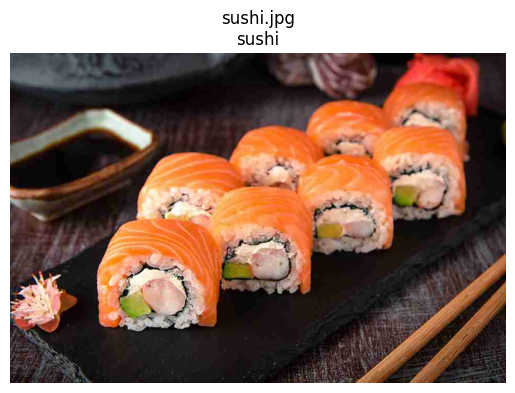

In [ ]:
test_img_path="sushi.jpg"
effnet_time=predict_timer(test_img_path, effnet_model, effnet_t)

###**1.5.Saving and Loading model**

In [ ]:
torch.save(effnet_model.state_dict(), "effnet_model.pth")
!zip -r '/content/effnet_model_saved_weights.zip' '/content/effnet_model.pth'

  adding: content/effnet_model.pth (deflated 8%)


In [ ]:
# from google.colab import files
# files.download('/content/effnet_model_saved_weights.zip')

###**1.6.Model Stats**

In [ ]:
from pathlib import Path

effnet_model_size= Path('/content/effnet_model.pth').stat().st_size/(1024**2)  #size returned is in B hence we divide by 1024^2 to get in MB
effnet_model_params=sum(torch.numel(param) for param in effnet_model.parameters()) #numel counts the number of elements in a tensor
effnet_stat={"model":"Effnet_B2","val_loss": round(val_loss,3), "val_acc":round(val_acc,3), "model_size[MB]": round(effnet_model_size,3), "model_params":effnet_model_params,
             "pred_time[s]":round(effnet_time, 3)}
effnet_stat

{'model': 'Effnet_B2',
 'val_loss': 0.68,
 'val_acc': 0.969,
 'model_size[MB]': 29.827,
 'model_params': 7705221,
 'pred_time[s]': 0.059}

##**2.Vit**

###**2.1.ViT Class**

In [ ]:
class ViT(nn.Module):
  def __init__(self):
    super().__init__()
    self.vit_weights=torchvision.models.ViT_B_16_Weights.DEFAULT
    self.vit_transfromer= self.vit_weights.transforms()
    self.loss=nn.CrossEntropyLoss()

  def create_model(self, num_classes):
    vit_model= torchvision.models.vit_b_16(weights=self.vit_weights)
    for params in vit_model.parameters():
      params.requires_grad=False

    vit_model.heads=nn.Sequential(nn.Dropout(0.2),
                                  nn.Linear(in_features=768, out_features=num_classes),
                                  nn.Softmax(dim=1))
    return self.vit_transfromer, vit_model

  def calc_loss_and_acc(self, y_preds, y):
    loss=self.loss(y_preds, y)
    y_preds=y_preds.argmax(dim=1)
    correct=torch.eq(y_preds, y).sum().item()
    acc=correct/len(y_preds)

    return loss, acc

In [ ]:
vit=ViT()
vit_t, vit_model=vit.create_model(num_classes=3)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:09<00:00, 36.2MB/s]


In [ ]:
summary(vit_model, input_size=(1,3,224,224), col_names=["input_size", "output_size", "num_params", "trainable"])

Layer (type:depth-idx)                        Input Shape               Output Shape              Param #                   Trainable
VisionTransformer                             [1, 3, 224, 224]          [1, 3]                    768                       Partial
├─Conv2d: 1-1                                 [1, 3, 224, 224]          [1, 768, 14, 14]          (590,592)                 False
├─Encoder: 1-2                                [1, 197, 768]             [1, 197, 768]             151,296                   False
│    └─Dropout: 2-1                           [1, 197, 768]             [1, 197, 768]             --                        --
│    └─Sequential: 2-2                        [1, 197, 768]             [1, 197, 768]             --                        False
│    │    └─EncoderBlock: 3-1                 [1, 197, 768]             [1, 197, 768]             (7,087,872)               False
│    │    └─EncoderBlock: 3-2                 [1, 197, 768]             [1, 197, 768]  

###**2.2.Datasets and dataloader**

In [ ]:
import os

train_dataset=torchvision.datasets.ImageFolder(root=train_dir,
                                               transform=vit_t)
test_dataset=torchvision.datasets.ImageFolder(root=test_dir,
                                               transform=vit_t)

train_dataloader=torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)
test_dataloader=torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=True, num_workers=os.cpu_count(), pin_memory=True)

In [ ]:
model=vit_model
criterion=vit.calc_loss_and_acc
optimizer=torch.optim.Adam(params=vit_model.parameters())
scheduler=torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer=optimizer)
log_vit=Report(EPOCHS)

###**2.3.Training**

In [ ]:
for epoch in range(EPOCHS):
  n=len(train_dataloader)
  for idx, inputs in enumerate(train_dataloader):
    loss, acc=train_step(model, inputs, optimizer, criterion)
    pos=epoch+(idx+1)/n
    log_vit.record(pos=pos, train_loss=loss, train_acc= acc, end="\r")

  n=len(test_dataloader)
  for idx, inputs in enumerate(test_dataloader):
    loss, acc=validate_step(model, inputs, criterion, scheduler)
    pos=epoch+(idx+1)/n
    log_vit.record(pos=pos, val_loss=loss, val_acc= acc, end="\r")

  log_vit.report_avgs(epoch+1)

EPOCH: 1.000  train_loss: 0.885  val_loss: 0.663  val_acc: 0.984  train_acc: 0.797  (9.62s - 86.59s remaining)
EPOCH: 2.000  train_loss: 0.670  val_loss: 0.628  val_acc: 0.951  train_acc: 0.946  (18.07s - 72.27s remaining)
EPOCH: 3.000  train_loss: 0.624  val_loss: 0.603  val_acc: 0.994  train_acc: 0.948  (26.10s - 60.90s remaining)
EPOCH: 4.000  train_loss: 0.615  val_loss: 0.585  val_acc: 0.994  train_acc: 0.960  (40.25s - 60.38s remaining)
EPOCH: 5.000  train_loss: 0.603  val_loss: 0.587  val_acc: 0.994  train_acc: 0.971  (50.88s - 50.88s remaining)
EPOCH: 6.000  train_loss: 0.599  val_loss: 0.587  val_acc: 0.994  train_acc: 0.965  (60.80s - 40.53s remaining)
EPOCH: 7.000  train_loss: 0.596  val_loss: 0.585  val_acc: 0.994  train_acc: 0.973  (72.74s - 31.17s remaining)
EPOCH: 8.000  train_loss: 0.595  val_loss: 0.574  val_acc: 0.994  train_acc: 0.973  (81.15s - 20.29s remaining)
EPOCH: 9.000  train_loss: 0.595  val_loss: 0.584  val_acc: 1.000  train_acc: 0.975  (92.10s - 10.23s rema

100%|██████████| 111/111 [00:00<00:00, 20635.04it/s]


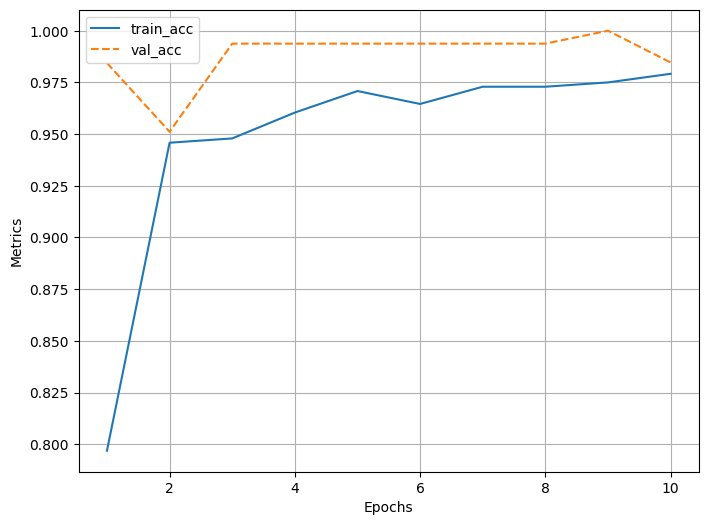

In [ ]:
log_vit.plot_epochs(["train_acc","val_acc"])

100%|██████████| 111/111 [00:00<00:00, 13056.47it/s]


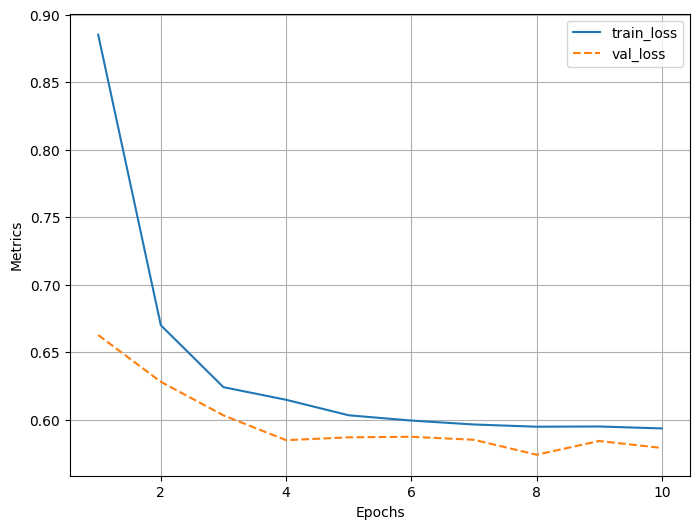

In [ ]:
log_vit.plot_epochs(["train_loss","val_loss"])

In [ ]:
val_loss=log_vit.report_avgs(10)["epoch_val_loss"];
val_acc=log_vit.report_avgs(10)["epoch_val_acc"];
val_loss, val_acc

EPOCH: 10.000  train_loss: 0.594  val_loss: 0.579  val_acc: 0.985  train_acc: 0.979  (102.27s - 0.00s remaining)
EPOCH: 10.000  train_loss: 0.594  val_loss: 0.579  val_acc: 0.985  train_acc: 0.979  (102.28s - 0.00s remaining)


(0.5791114807128906, 0.984659090909091)

###**2.4.Pred_timer**

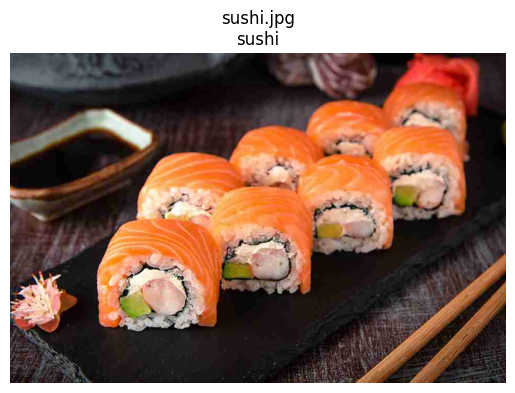

In [ ]:
test_img_path="sushi.jpg"
vit_time=predict_timer(test_img_path, vit_model, vit_t)

###**2.5.Saving and Loading model**

In [ ]:
torch.save(vit_model.state_dict(), "vit_model.pth")
!zip -r '/content/vit_model_saved_weights.zip' '/content/vit_model.pth'

  adding: content/vit_model.pth (deflated 7%)


In [ ]:
# from google.colab import files
# files.download('/content/vit_model_saved_weights.zip')

###**2.6.Model Stats**

In [ ]:
from pathlib import Path

vit_model_size= Path('/content/vit_model.pth').stat().st_size/(1024**2)  #size returned is in B hence we divide by 1024^2 to get in MB
vit_model_params=sum(torch.numel(param) for param in vit_model.parameters())
vit_stat={"model":"ViT","val_loss": round(val_loss,3), "val_acc":round(val_acc,3), "model_size[MB]": round(vit_model_size,3), "model_params":vit_model_params,
          "pred_time[s]": round(vit_time,3)}
vit_stat

{'model': 'ViT',
 'val_loss': 0.579,
 'val_acc': 0.985,
 'model_size[MB]': 327.362,
 'model_params': 85800963,
 'pred_time[s]': 0.025}

#**Model Performance**

In [ ]:
import pandas as pd
performance_df=pd.DataFrame([effnet_stat, vit_stat])
performance_df.set_index("model", inplace=True)
performance_df

,val_loss,val_acc,model_size[MB],model_params,pred_time[s]
model,,,,,
Effnet_B2,0.680,0.969,29.827,7705221,0.059
ViT,0.579,0.985,327.362,85800963,0.025


**EffnetB2 performs considerably well, hence we shall deploy EffnetB2**

#**Deployment on Gradio** : [temporary] ```gradio.Interface(fn, inputs, outputs, ···)```

In [ ]:
!pip -q install gradio;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 20.0/20.0 MB 18.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.3/288.3 kB 29.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.4/75.4 kB 9.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 236.8/236.8 kB 24.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.5/50.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 137.0/137.0 kB 16.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.9/129.9 kB 15.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 58.3/58.3 kB 7.7 MB/s eta 0:0

##**fn_parameter**

In [ ]:
import gradio as gr

def effnet_deploy(img):
  model=effnet_model.to("cpu") #gradio offers only cpu for free
  ts=time.perf_counter()
  img_t=effnet_t(img).unsqueeze(0)
  model.eval()
  with torch.inference_mode():
    y_preds=model(img_t)
    pred_dict={"pizza":y_preds[0][0].item(), "steak":y_preds[0][1].item(), "sushi":y_preds[0][2].item()}
    tf=time.perf_counter()
  return pred_dict, round(tf-ts, 3)

In [ ]:
effnet_deploy(Image.open(test_img_path))

({'pizza': 0.021716060116887093,
  'steak': 0.020584937185049057,
  'sushi': 0.9576990008354187},
 0.236)

##**examples_parameter**

In [ ]:
examples_list=[["/content/steak.jpg"],
               ["/content/sushi.jpg"],
               ["/content/pizza.jpg"]]

##**Gradio interface**

In [ ]:
title= "FoodVision Mini 🍕🥩🍣"
description= "[EffnetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) to classify images as pizza/steak/sushi"
demo=gr.Interface(fn=effnet_deploy,
                  inputs=gr.Image(type= "pil"),
                  outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                           gr.Number(label="Prediction time[s]")],
                  examples=examples_list,
                  title=title,
                  description=description)

demo.launch(debug=False,
            share=True)

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
Running on public URL: https://1d7860241dcee64cf4.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


**The Gradio deployment link expires after 72 hrs so you can either re run the cells, or look at the attached snippet**

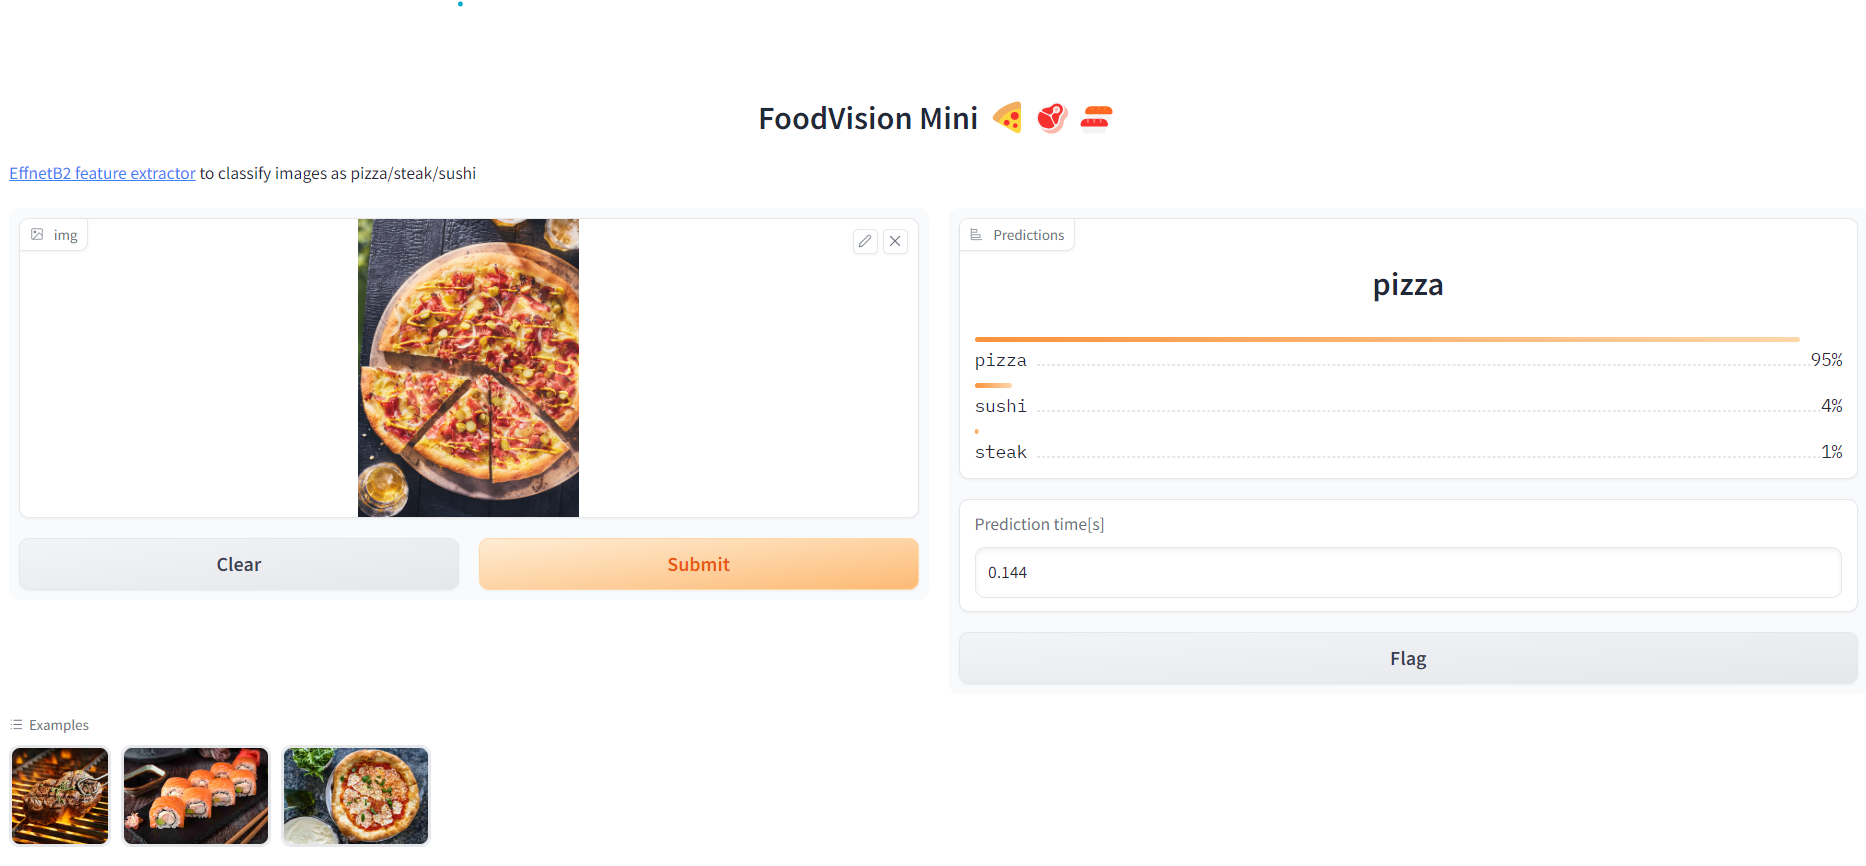

#**Deployment on hugging Face**:[permanent]

##**The necessary dirs**

In [ ]:
from pathlib import Path
import shutil

foodvision_mini_path=Path("demos/foodvision_mini")
if foodvision_mini_path.exists():
  shutil.rmtree(foodvision_mini_path)
  foodvision_mini_path.mkdir(parents=True, exist_ok=True)

else: foodvision_mini_path.mkdir(parents=True, exist_ok=True)

###**Examples dir**

In [ ]:
foodvision_mini_examples=foodvision_mini_path/"examples"
foodvision_mini_examples.mkdir(parents=True, exist_ok=True)

destination=foodvision_mini_examples
src= examples_list

for example in examples_list:
  example=Path(example[0])
  shutil.copy2(example, foodvision_mini_examples/example.name)

###**Model_weights**

In [ ]:
src="/content/effnet_model.pth"
destination=foodvision_mini_path

shutil.copy2(src, destination/"effnet_model_weights.pth")

» demos/foodvision_mini/effnet_model_weights.pth

In [ ]:
import os
os.listdir(foodvision_mini_path)

['examples', 'effnet_model_weights.pth']

###**Model initialization**

In [ ]:
%%writefile demos/foodvision_mini/effnet_model_creation.py
import torch
from torch import nn
import torchvision

class EFFNET_B2(nn.Module):
  def __init__(self):
    super().__init__()
    self.effnet_weights=torchvision.models.EfficientNet_B2_Weights.DEFAULT
    self.effnet_transfromer= self.effnet_weights.transforms()
    self.loss=nn.CrossEntropyLoss()

  def create_model(self, num_classes):
    effnet_model= torchvision.models.efficientnet_b2(weights=self.effnet_weights)
    for params in effnet_model.parameters():
      params.requires_grad=False

    effnet_model.classifier=nn.Sequential(nn.Dropout(0.2),
                                          nn.Linear(in_features=1408, out_features=num_classes),
                                          nn.Softmax(dim=1))
    return self.effnet_transfromer, effnet_model

  def calc_loss_and_acc(self, y_preds, y):
    loss=self.loss(y_preds, y)
    y_preds=y_preds.argmax(dim=1)
    correct=torch.eq(y_preds, y).sum().item()
    acc=correct/len(y_preds)

    return loss, acc

Writing demos/foodvision_mini/effnet_model_creation.py


###**App**

In [ ]:
%%writefile demos/foodvision_mini/app.py
# 1.necessary imports
import gradio as gr
import torch
from torch import nn
import time
import os
from effnet_model_creation import EFFNET_B2

# 2.model creation
eff=EFFNET_B2()
effnet_t, effnet_model= eff.create_model(num_classes=3)

# 3.loading model weights
effnet_model.load_state_dict(torch.load("effnet_model_weights.pth",
                                        map_location=torch.device("cpu"))) #load the model onto cpu

# 4.gradio_fn
def effnet_deploy(img):
  model=effnet_model.to("cpu") #gradio offers only cpu for free
  ts=time.perf_counter()
  img_t=effnet_t(img).unsqueeze(0)
  model.eval()
  with torch.inference_mode():
    y_preds=model(img_t)
    pred_dict={"pizza":y_preds[0][0].item(), "steak":y_preds[0][1].item(), "sushi":y_preds[0][2].item()}
    tf=time.perf_counter()
  return pred_dict, round(tf-ts, 3)

# 5.example_list
examples_list=[["examples/"+example] for example in os.listdir("examples")]

# 6.setting up gradio app
title= "FoodVision Mini 🍕🥩🍣"
description= "[EffnetB2 feature extractor](https://pytorch.org/vision/main/models/generated/torchvision.models.efficientnet_b2.html) to classify images as pizza/steak/sushi"
demo=gr.Interface(fn=effnet_deploy,
                  inputs=gr.Image(type= "pil"),
                  outputs=[gr.Label(num_top_classes=3, label="Predictions"),
                           gr.Number(label="Prediction time[s]")],
                  examples=examples_list,
                  title=title,
                  description=description)

# 7.launch
demo.launch(share=True) #does not require other params

Writing demos/foodvision_mini/app.py


###**Requirements.txt** :necessary imports that huggingface space needs to make for our app to run.

In [ ]:
%%writefile demos/foodvision_mini/requirements.txt
torch==2.0.1
torchvision==0.15.2
gradio==3.34.0

Writing demos/foodvision_mini/requirements.txt


In [ ]:
torch.__version__

'2.0.1+cu118'

In [ ]:
gr.__version__

'3.34.0'

In [ ]:
torchvision.__version__

'0.15.2+cu118'

###**Downloading demos**

In [ ]:
from google.colab import files

!zip -r 'demos.zip' '/content/demos' #r->recursive mode to zip all the files within as well
files.download('demos.zip')

updating: content/demos/ (stored 0%)
updating: content/demos/foodvision_mini/ (stored 0%)
updating: content/demos/foodvision_mini/examples/ (stored 0%)
updating: content/demos/foodvision_mini/examples/sushi.jpg (deflated 2%)
updating: content/demos/foodvision_mini/examples/pizza.jpg (deflated 0%)
updating: content/demos/foodvision_mini/examples/steak.jpg (deflated 0%)
updating: content/demos/foodvision_mini/effnet_model_creation.py (deflated 56%)
updating: content/demos/foodvision_mini/requirements.txt (deflated 4%)
updating: content/demos/foodvision_mini/effnet_model_weights.pth (deflated 8%)
  adding: content/demos/foodvision_mini/app.py (deflated 52%)
  adding: content/demos/foodvision_mini/.ipynb_checkpoints/ (stored 0%)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

#**Deployed app**

**Link**:https://jothish-foodvision-mini.hf.space

In [ ]:
from IPython.display import IFrame

# Embed FoodVision Mini Gradio demo
IFrame(src="https://hf.space/embed/Jothish/foodvision_mini/+", width=900, height=750)